In [1]:
# import all modules needed
import models.eda as eda

import pandas as pd
import numpy as np
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample

from xgboost import XGBClassifier

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [2]:
# load train and test set
print("loading datasets...")
client = eda.load_data("data/train/client_train.csv")
invoice = eda.load_data("data/train/invoice_train.csv")
df = eda.feature_change(client, invoice)


loading datasets...


/var/folders/zj/y95dm4bn0jz_s678nqhm92b80000gn/T/ipykernel_31203/4046620202.py:4: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  invoice = eda.load_data("data/train/invoice_train.csv")


In [3]:
df.head()

,district,client_id,client_catg,region,target,region_group,coop_time,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,months_number,counter_type,invoice_month,invoice_year,is_weekday,total_consumption
0,60,0,11,101,0.0,200,288,11,1335667,0,203,8,1,4,1,3,2014,0.0,82
1,60,0,11,101,0.0,200,288,11,1335667,0,203,6,1,4,1,3,2013,0.0,1384
2,60,0,11,101,0.0,200,288,11,1335667,0,203,8,1,4,1,3,2015,0.0,123
3,60,0,11,101,0.0,200,288,11,1335667,0,207,8,1,4,1,7,2015,0.0,102
4,60,0,11,101,0.0,200,288,11,1335667,0,207,9,1,12,1,11,2016,0.0,572


## Baseline model
- our very simple baseline model assumes every client from district 51 is fraudulent. 

In [4]:
def baseline_model(X):
    y_pred = [0 if cat != 51 else 1 for cat in X.client_catg]
    return y_pred

# in district 51 the most fraudulents appear:
pd.crosstab(df['target'], df['client_catg'], normalize='columns')*100

client_catg,11,12,51
target,,,
0.0,92.391486,94.413284,79.044952
1.0,7.608514,5.586716,20.955048


In [5]:
# Select the features to use for modeling
X_train = df.drop("target", axis=1)
y_train = df.target
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

y_pred = baseline_model(X_test)

print('F1-score:', precision_score(y_test, y_pred).round(2))
print('ROC AUC:', roc_auc_score(y_test, y_pred).round(2))

F1-score: 0.21
ROC AUC: 0.52


## Customized sampling and train test spilt
- the dataset is highly biased
    1. down sampling for train set: split fraudulent clients 70/30 and use the number of clients in the 70% to choose the same amount of hones clients. 
    2. sampling for test set: use the number of fraudulent clients from 30% and add amount of honest clients to match the original fraction of hones/fraudulent clients

In [6]:
train, test = eda.sampling(df)

## Feature engineering
- idea: add historical informations from former invoices as new feature
- takes very long and the model does not get better

In [7]:
# train = eda.feature_engineering(train)
# test = eda.feature_engineering(test)

## Feature target split

In [8]:
X_train, y_train = eda.feature_target_split(train)
X_test, y_test = eda.feature_target_split(test)

## Scaling

In [9]:
# scaling of the data
scaler_down = StandardScaler()
X_train_preprocessed = scaler_down.fit_transform(X_train)
X_test_preprocessed = scaler_down.transform(X_test)

## Simple Logistic regression

In [29]:
# Fit logistic regression model on the training data
lr = LogisticRegression(random_state=42)
lr.fit(X_train_preprocessed, y_train)

# Predict on test data using logistic regression model
y_pred_lr = lr.predict(X_test_preprocessed)

eda.print_metrics(y_test, y_pred_lr)

Accuracy: 0.29
Precision: 0.09
Recall: 0.89
F1 Score: 0.16
ROC AUC Score: 0.56


## XGBoost (on customized downsampled dataset)

In [12]:
# Define XGBoost model 
xgb_model = XGBClassifier(
    objective="binary:logistic",
    seed=42,
    enable_categorical=True,
    tree_method="hist",
    n_estimators=200,
    max_depth=15,
    learning_rate=0.1,
).fit(X_train_preprocessed, y_train)
y_pred = xgb_model.predict(X_train_preprocessed)
eda.print_metrics(y_train, y_pred)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC AUC Score: 1.00


In [16]:
y_test_pred = xgb_model.predict(X_test_preprocessed)
eda.print_metrics(y_test, y_test_pred)

Accuracy: 0.46
Precision: 0.09
Recall: 0.72
F1 Score: 0.17
ROC AUC Score: 0.58


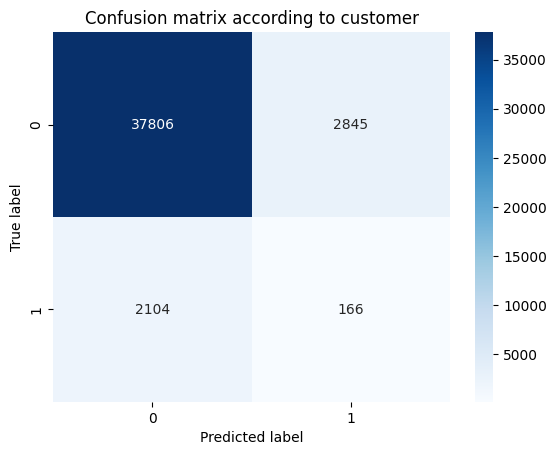

In [27]:
# make confusionmatrix according to customers 
X_test["target_pred"] = pd.Series(y_pred)
X_test["target"] = y_test.values.astype(int)

y_pred_client = X_test.groupby("client_id")["target_pred"].any().astype(int)
y_true_client = X_test.groupby("client_id")["target"].any().astype(int)


# eda.print_metrics(y_test, y_pred)
cm = confusion_matrix(y_true_client, y_pred_client)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion matrix according to customer")
plt.show()

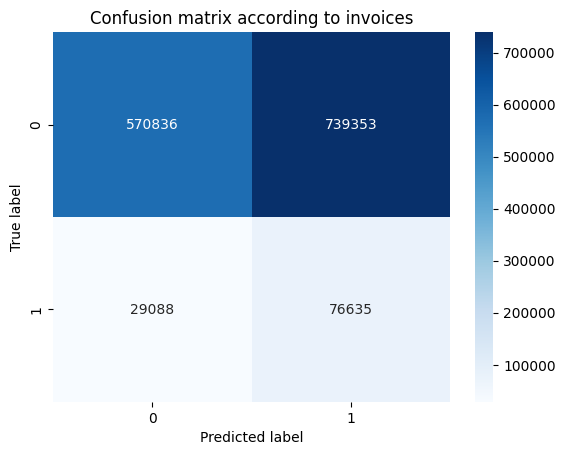

In [28]:
# make confusionmatrix according to invoices 

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion matrix according to invoices")
plt.show()

## Final remarks

- the model seems to overfit the train data 
- the model does not perform well on the biased test set